In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from surprise import SVD, model_selection, accuracy, Reader, Dataset

In [31]:
def parse(filename = 'data/movies.txt'):
    features = ["Movie Id", "Movie Title", "Unknown", "Action", "Adventure", "Animation", "Childrens", "Comedy", "Crime",
         "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
         "Thriller", "War", "Western"]
    genresdict = {}
    genres = features[3:]
    for g in genres:
        genresdict[g] = []

    for row in np.loadtxt(filename, dtype=str, delimiter='\t', encoding='latin1'):
        movie_id = int(row[0])
        movie_genres = row[3:]
        for index, indicator in enumerate(movie_genres):
            if indicator=="1":
                genre = genres[index]
                genresdict[genre].append(movie_id)
    return genresdict

# No bias

In [22]:
class no_bias:
    def grad_U(Ui, Yij, Vj, reg, eta):
        """
        Takes as input Ui (the ith row of U), a training point Yij, the column
        vector Vj (jth column of V^T), reg (the regularization parameter lambda),
        and eta (the learning rate).

        Returns the gradient of the regularized loss function with
        respect to Ui multiplied by eta.
        """
        return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj)))

    def grad_V(Vj, Yij, Ui, reg, eta):
        """
        Takes as input the column vector Vj (jth column of V^T), a training point Yij,
        Ui (the ith row of U), reg (the regularization parameter lambda),
        and eta (the learning rate).

        Returns the gradient of the regularized loss function with
        respect to Vj multiplied by eta.
        """
        return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj)))

    def get_err(U, V, Y, reg=0.0):
        """
        Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
        j is the index of a movie, and Y_ij is user i's rating of movie j and
        user/movie matrices U and V.

        Returns the mean regularized squared-error of predictions made by
        estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
        """
        if reg == 0.0:
            reg_error = 0
        else:
            reg_error = reg / 2 * \
                        (np.linalg.norm(U, ord='fro') ** 2 +
                         np.linalg.norm(V, ord='fro') ** 2)
        sq_error = 0
        for i, j, Yij in Y:
            sq_error += 0.5 * ((Yij - np.dot(U[i - 1], V[j - 1])) ** 2)
        return (reg_error + sq_error) / len(Y)


    def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
        """
        Given a training data matrix Y containing rows (i, j, Y_ij)
        where Y_ij is user i's rating on movie j, learns an
        M x K matrix U and N x K matrix V such that rating Y_ij is approximated
        by (UV^T)_ij.

        Uses a learning rate of <eta> and regularization of <reg>. Stops after
        <max_epochs> epochs, or once the magnitude of the decrease in regularized
        MSE between epochs is smaller than a fraction <eps> of the decrease in
        MSE after the first epoch.

        Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
        of the model.
        """
        U = np.random.rand(M, K) - 0.5
        V = np.random.rand(N, K) - 0.5

        ep_1_e = 0
        last_e = no_bias.get_err(U, V, Y, reg)
        new_e = no_bias.get_err(U, V, Y, reg)

        for epoch in range(max_epochs):
            np.random.shuffle(Y)
            last_e = new_e

            for r in range(Y.shape[0]):
                i, j, Yij = Y[r][0] - 1, Y[r][1] - 1, Y[r][2]
                dU = no_bias.grad_U(U[i], Yij, V[j], reg, eta)
                dV = no_bias.grad_V(V[j], Yij, U[i], reg, eta)
                U[i] -= dU
                V[j] -= dV
            new_e = no_bias.get_err(U, V, Y, reg)
            if epoch == 0:
                ep_1_e = last_e - new_e
            else:
                if ((last_e - new_e) / ep_1_e) < eps:
                    return (U, V, last_e)
        return (U, V, last_e)

# Bias

In [25]:
class bias:
    def grad_U(Ui, Yij, Vj, ai, bj, reg, eta):
        """
        Takes as input Ui (the ith row of U), a training point Yij, the column
        vector Vj (jth column of V^T), reg (the regularization parameter lambda),
        and eta (the learning rate).
        
        *** and bias terms: ai for the ith user, bj for the jth movie ***

        Returns the gradient of the regularized loss function with
        respect to Ui multiplied by eta.
        """
        return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj) - ai - bj))

    def grad_V(Vj, Yij, Ui, ai, bj, reg, eta):
        """
        Takes as input the column vector Vj (jth column of V^T), a training point Yij,
        Ui (the ith row of U), reg (the regularization parameter lambda),
        and eta (the learning rate).
        
        *** and bias terms: ai for the ith user, bj for the jth movie ***

        Returns the gradient of the regularized loss function with
        respect to Vj multiplied by eta.
        """
        return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj) - ai - bj))

    def get_err(U, V, a, b, Y, reg=0.0):
        """
        Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
        j is the index of a movie, and Y_ij is user i's rating of movie j and
        user/movie matrices U and V.
        
        *** also, matrices of bias terms a, b ***

        Returns the mean regularized squared-error of predictions made by
        estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
        """
        if reg == 0.0:
            reg_error = 0
        else:
            reg_error = reg / 2 * \
                        (np.linalg.norm(U, ord='fro') ** 2 +
                         np.linalg.norm(V, ord='fro') ** 2)
        sq_error = 0
        for i, j, Yij in Y:
            sq_error += 0.5 * ((Yij - np.dot(U[i - 1], V[j - 1]) - a[i - 1] - b[j - 1]) ** 2)
        return (reg_error + sq_error) / len(Y)
    
    def gradient_bias(Ui, Vj, Yij, ai, bj, eta):
        return -eta * (Yij - np.dot(Ui, Vj) - ai - bj)

    def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
        """
        Given a training data matrix Y containing rows (i, j, Y_ij)
        where Y_ij is user i's rating on movie j, learns an
        M x K matrix U and N x K matrix V such that rating Y_ij is approximated
        by (UV^T)_ij.

        Uses a learning rate of <eta> and regularization of <reg>. Stops after
        <max_epochs> epochs, or once the magnitude of the decrease in regularized
        MSE between epochs is smaller than a fraction <eps> of the decrease in
        MSE after the first epoch.

        Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
        of the model.
        """
        U = np.random.rand(M, K) - 0.5
        V = np.random.rand(N, K) - 0.5
        a = np.random.rand(M, ) - 0.5
        b = np.random.rand(N, ) - 0.5

        ep_1_e = 0
        last_e = bias.get_err(U, V, a, b, Y, reg)
        new_e = bias.get_err(U, V, a, b, Y, reg)

        for epoch in range(max_epochs):
            np.random.shuffle(Y)
            last_e = new_e

            for r in range(Y.shape[0]):
                i, j, Yij = Y[r][0] - 1, Y[r][1] - 1, Y[r][2]
                dU = bias.grad_U(U[i], Yij, V[j], a[i], b[j], reg, eta)
                dV = bias.grad_V(V[j], Yij, U[i], a[i], b[j], reg, eta)
                grad = bias.gradient_bias(U[i], V[j], a[i], b[j], eta)
                U[i] -= grad
                V[j] -= grad
            new_e = bias.get_err(U, V, a, b, Y, reg)
            if epoch == 0:
                ep_1_e = last_e - new_e
            else:
                if ((last_e - new_e) / ep_1_e) < eps:
                    return (U, V, last_e)
        return (U, V, last_e)

In [26]:
# model (biased)

Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

K = 20
reg = 0.1
eta = 0.01
epsilon = 0.00005

U, V, err = no_bias.train_model(M, N, K, eta, reg, Y_train, epsilon)
print(no_bias.get_err(U, V, Y_test))
V = V.transpose()

Factorizing with  943  users,  1682  movies.
0.43316087857612995


In [27]:
# model (SVD)

reader = Reader()
Y_train = Dataset.load_from_file('data/data.txt', reader)
Y_train  = Y_train.build_full_trainset()
algo = SVD(n_factors=25, n_epochs=300, biased=True, lr_all = 0.01, reg_all = 0.1)
algo.fit(Y_train)
V = algo.qi.transpose()

In [28]:
A = np.linalg.svd(V)[0]
V_proj = np.dot(A[:, :2].transpose(), V)
V_proj /= V_proj.std(axis=1).reshape(2, 1)

data = np.loadtxt('data/data.txt').astype(int)
N = max(data[:,1]).astype(int) # movies
num_ratings = np.zeros(N)
tot_ratings = np.zeros(N)

for row in data:
    j = row[1] - 1
    y = row[2]
    num_ratings[j] += 1
    tot_ratings[j] += y
    
avg_ratings = tot_ratings / num_ratings

In [51]:
def plot(idx, plot_title):
    plt.figure(figsize=(11,11))
    # plt.scatter(V_proj[0], V_proj[1], s=num_ratings, c=avg_ratings, alpha=0.6) # cmap=plt.get_cmap('RdYlGn')
    plt.scatter(V_proj[0], V_proj[1], s=num_ratings, c=avg_ratings)
    plt.colorbar().set_label("Average rating")
    plt.title(plot_title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    for movie_id, title in movies[['Movie Id', 'Movie Title']].values[idx]:
        x, y = V_proj[0][movie_id-1], V_proj[1][movie_id-1]
        plt.annotate(title, xy=(x, y), horizontalalignment='center', verticalalignment='center', fontsize=8, rotation=0, arrowprops=dict(arrowstyle='-', lw=1, alpha=0.5))
    plt.savefig('plots/' + plot_title + '.png')
    plt.show()

In [32]:
movie_features = ["Movie Id", "Movie Title", "Unknown", "Action", "Adventure", "Animation", "Childrens", "Comedy", "Crime",
         "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", 
         "Thriller", "War", "Western"]
movies = pd.read_csv('data/movies.txt', delimiter='\t', header=None, encoding='latin1', names=movie_features)

chosen_idx = np.array([0, 21, 167, 707, 762, 749, 687, 1013, 1090, 1414])

popular_idx = np.argsort(num_ratings)[-10:]
best_idx = np.argsort(avg_ratings)[-10:]

genre_dict = parse('data/movies.txt')
comedy_ids = genre_dict['Comedy']
horror_ids = genre_dict['Horror']
sci_fi_ids = genre_dict['Sci-Fi']
comedy_idx = np.random.choice(comedy_ids, 10) - 1
horror_idx = np.random.choice(horror_ids, 10) - 1
sci_fi_idx = np.random.choice(sci_fi_ids, 10) - 1

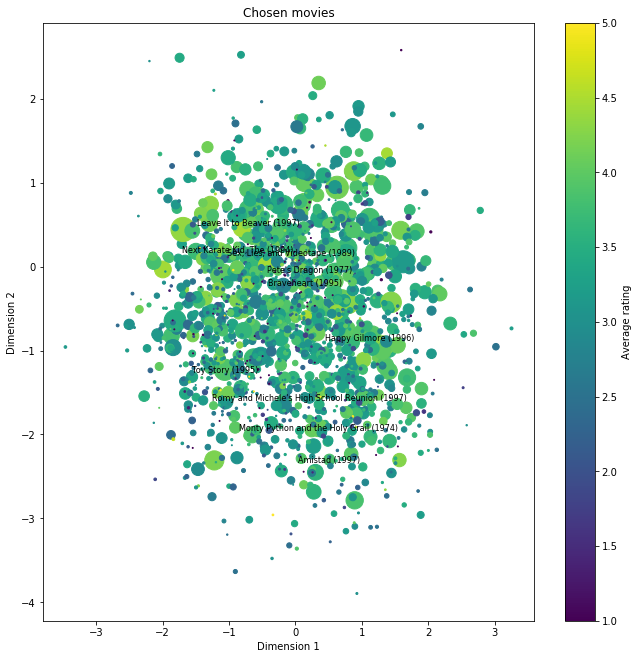

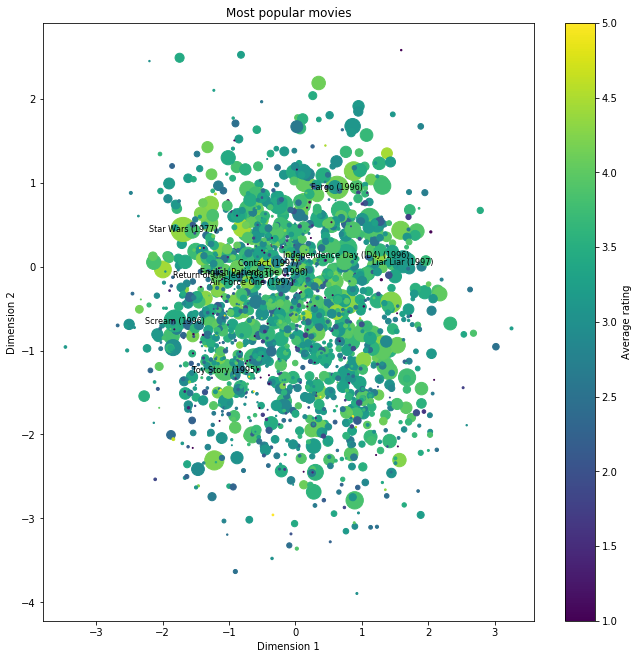

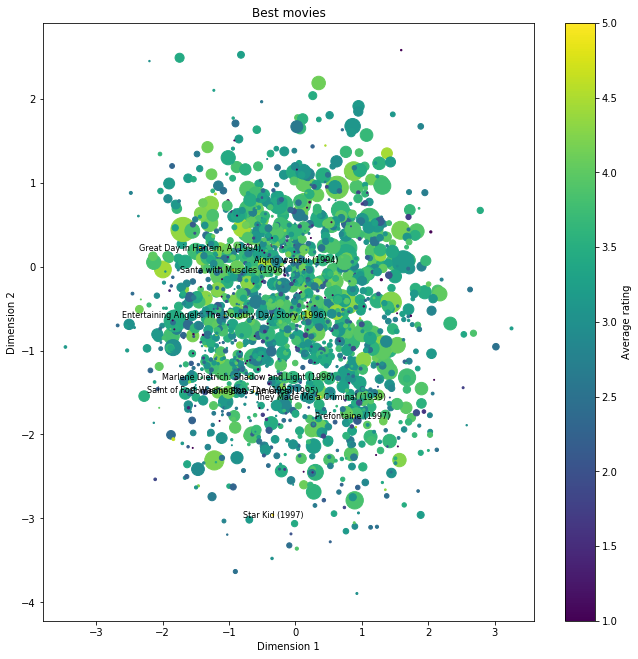

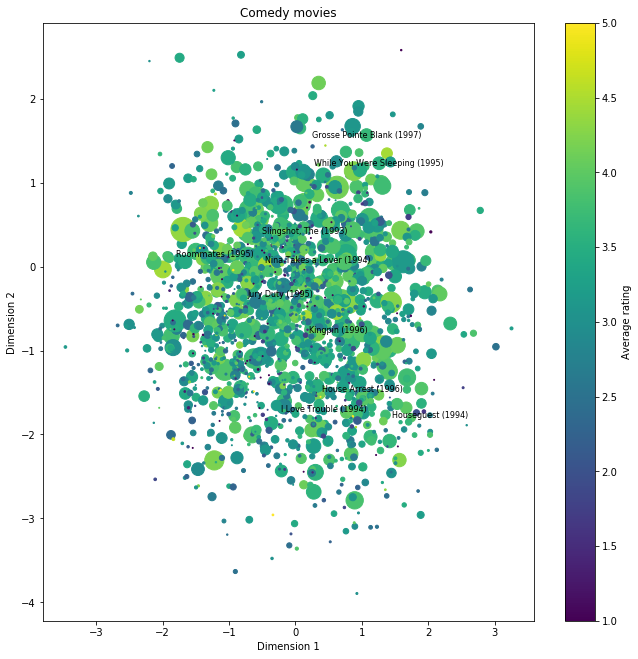

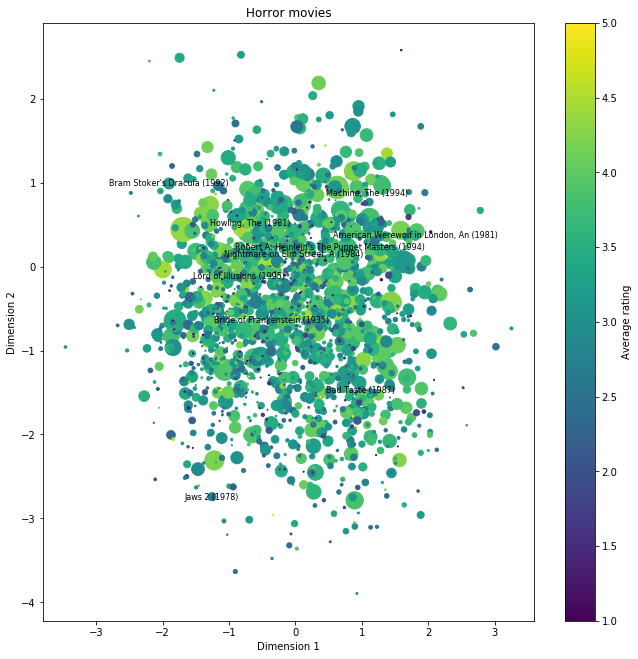

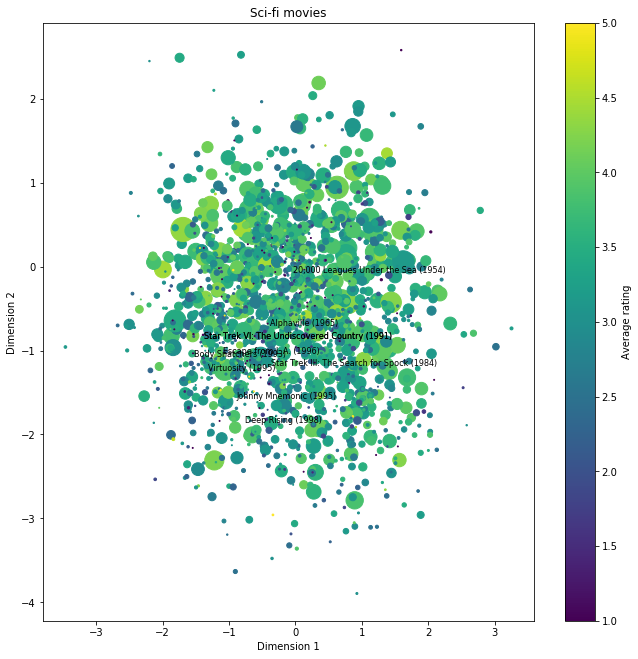

In [52]:
plot(chosen_idx, 'Chosen movies')
plot(popular_idx, 'Most popular movies')
plot(best_idx, 'Best movies')
plot(comedy_idx, 'Comedy movies')
plot(horror_idx, 'Horror movies')
plot(sci_fi_idx, 'Sci-fi movies')